## Tutorial 9. Pearson and correlation and chi-square test


Created by Emanuel Flores-Bautista 2019.  All content contained in this notebook is licensed under a [Creative Commons License 4.0](https://creativecommons.org/licenses/by/4.0/). The code is licensed under a [MIT license](https://opensource.org/licenses/MIT).

In [53]:
import numpy as np
import numba
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import TCD19_utils as TCD

TCD.set_plotting_style_2()

#Magic command to enable plotting inside notebook
%matplotlib inline

#Magic command to enable svg format in plots
%config InlineBackend.figure_format = 'svg'

In [2]:
df = pd.read_csv('../data/data_CONAPO_municipal_90-15.csv', encoding = "ISO-8859-1")

In [3]:
df = df.rename(columns = {'SPRIM': '% sin primaria', 
                       'OVSD': '% sin drenaje', 
                       'ANALF': '% analfabeta', 
                       'OVSEE': '% sin energía eléctrica', 
                       'OVPT': '% con piso de tierra', 
                       'GM': 'Grado de marginación', 
                       'PO2SM': '% con ingresos de menos de 2 salarios mín.',
                       'OVSAE': '% sin agua entubada',
                        'IM': 'índice de marginación'})

In [40]:
df = df.apply(pd.to_numeric, errors='coerce')

In [4]:
df.head(3)

,CVE_ENT,ENT,CVE_MUN,MUN,POB_TOT,VP,% analfabeta,% sin primaria,OVSDE,% sin energía eléctrica,...,PL<5000,% con ingresos de menos de 2 salarios mín.,% sin drenaje,OVSDSE,índice de marginación,Grado de marginación,IND0A100,LUG_NAC,LUGAR_EST,AÑO
0,1,Aguascalientes,1001,Aguascalientes,877190,-,2.06,9.54,0.31,0.16,...,8.73,31.13,-,-,-1.676,Muy bajo,-,2408,11,2015
1,1,Aguascalientes,1001,Aguascalientes ...,797010,-,2.59,11.48,0.49,0.31,...,8.73,29.9,-,-,-1.768,Muy bajo,7.69,2409,-,2010
2,1,Aguascalientes,1001,Aguascalientes,723043,-,3.19,13.61,0.77,0.54,...,8.21,28.37,-,-,-1.831,Muy bajo,-,2419,11,2005


In [48]:
df_pearson = df[['% con ingresos de menos de 2 salarios mín.', '% sin primaria']].dropna()

In [49]:
df_pearson.head(3)

,% con ingresos de menos de 2 salarios mín.,% sin primaria
0,31.13,9.54
1,29.90,11.48
2,28.37,13.61


In [50]:
df_pearson = df_pearson.apply(pd.to_numeric, errors='coerce')

In [66]:
df_pearson.corr()

,% con ingresos de menos de 2 salarios mín.,% sin primaria
% con ingresos de menos de 2 salarios mín.,1.00000,0.76207
% sin primaria,0.76207,1.00000


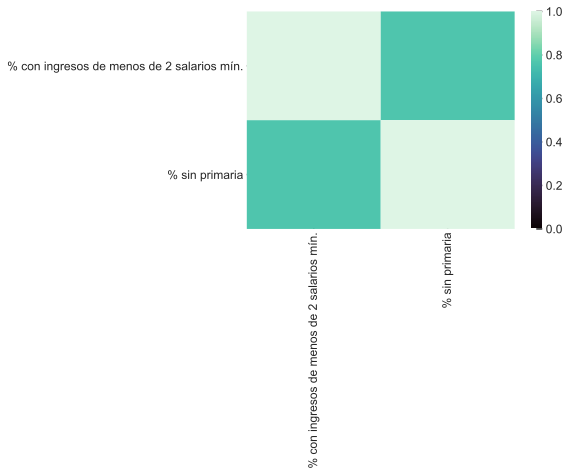

In [51]:
sns.heatmap(df_pearson.corr(), cmap = 'mako', robust = True, vmin = 0, vmax = 1)

In [28]:
df_pearson['margi_edu'] = (df_pearson['% sin primaria'] >
                    df_pearson['% sin primaria'].median())

df_pearson['margi_econ'] = (df_pearson['% con ingresos de menos de 2 salarios mín.'] >
                      df_pearson['% con ingresos de menos de 2 salarios mín.'].median())

In [29]:
contingency = pd.crosstab(df_pearson['margi_edu'], df_pearson['margi_econ'])

contingency

margi_econ,False,True
margi_edu,,
False,7354,1184
True,1184,4924


In [34]:
p_val = stats.chi2_contingency(contingency)[1]

p_val

0.0

In [45]:
edu = df['% sin primaria'].dropna().values

econ = df['% con ingresos de menos de 2 salarios mín.'].dropna().values

In [46]:
stats.pearsonr(np.array(edu), np.array(econ))

(0.7620697693460955, 0.0)

## Bootstrap test for pearson correlation

In [61]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

@numba.jit(nopython=True)
def draw_bs_pairs(x, y):
    """
    Draw a pairs bootstrap sample.
    """
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)
    return x[bs_inds], y[bs_inds]


@numba.jit(nopython=True)
def pearson_r(x, y):
    """
    Compute Pearson correlation coefficient.
    """
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.std(x) / np.std(y) \
                / np.sqrt(len(x)) / np.sqrt(len(y))

In [59]:
@numba.jit(nopython=True)
def draw_bs_pairs_reps_pearson(x, y, size=10000):
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = pearson_r(*draw_bs_pairs(x, y))
    return out

In [64]:
# Get reps
bs_reps_pearson = draw_bs_pairs_reps_pearson(edu, econ)

# Get the confidence intervals
conf_int_edu_econ = np.percentile(bs_reps_pearson, [2.5, 97.5])

conf_int_edu_econ

### Pearson r p-value